In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
from pathlib import Path
import logging
from random import shuffle

import numpy as np
import pandas as pd

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

data_path = Path('data', 'yelp')
results_path = Path('results', 'yelp')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Logging Config
logging.basicConfig(filename=results_path / 'doc2vec.log', level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')

In [4]:
df = pd.read_parquet(data_path / 'user_reviews.parquet').loc[:, ['stars', 'text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3495140 entries, 0 to 3495139
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   stars   float64
 1   text    object 
dtypes: float64(1), object(1)
memory usage: 80.0+ MB


In [5]:
df.stars.value_counts()

5.0    1609748
4.0     729936
1.0     535916
3.0     346817
2.0     272723
Name: stars, dtype: int64

In [6]:
stars = range(1, 6)
sample = pd.concat([df[df.stars == s].sample(n=100000) for s in stars])
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 247977 to 3042911
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   500000 non-null  float64
 1   text    500000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.4+ MB


In [7]:
sample.stars.value_counts()

1.0    100000
2.0    100000
3.0    100000
4.0    100000
5.0    100000
Name: stars, dtype: int64

In [8]:
sample.to_parquet(results_path / 'review_sample.parquet')
sample = pd.read_parquet(results_path / 'review_sample.parquet').reset_index(drop=True)
sample.head()

,stars,text
0,1.0,Inept registration staff. \nRoom smelled like ...
1,1.0,I live in an apartment complex to start off.. ...
2,1.0,"We wer at the Ipod, but et was Ihap! Oh ma gaw..."
3,1.0,I decided to try this salon because I heard on...
4,1.0,I can't even believe this place hasn't been sh...


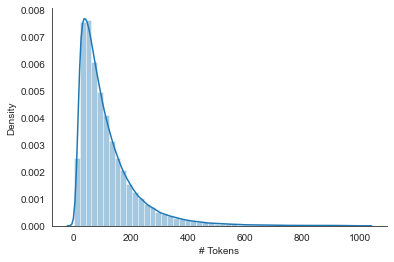

In [9]:
ax = sns.distplot(sample.text.str.split().str.len())
ax.set_xlabel('# Tokens')
sns.despine();

In [10]:
# Doc2Vec

# Basic text cleaning
tokenizer = RegexpTokenizer(r'\w+') # \w+ : at least 1 letter or number
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

sample.text = sample.text.str.lower().apply(clean)
sample.sample(n=10)

,stars,text
50700,1.0,better signing one downtown overall gyms clean...
497227,5.0,great place friends dates used live santa barb...
367928,4.0,heard fern bars well bar greenhouse like might...
168421,2.0,first time actually going store versus caterin...
457835,5.0,great food friendly employees decent beer sele...
250136,3.0,went first time beautiful sunday afternoon par...
335710,4.0,like giant sloppy burritos stuffed meat place ...
248538,3.0,went place gone pandemic sides flavorful reall...
479852,5.0,pizza delicious hands best service ever server...
23678,1.0,consistently dopey staff sent wrong supplies m...


In [11]:
# sample limit > 10 tokens
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485473 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   485473 non-null  float64
 1   text    485473 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.1+ MB


In [62]:
# Create sentence stream
sentences = []
for i, (_, text) in enumerate(sample.values):
    # TaggedDocument creation by words and tag(can be category or document title...)
    # Similarity results can also use the tag as a reference point for tagged categories, so sometimes seemingly unrelated content is output. Thus, the tag should consider what the results should be
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

# Doc2Vec MDL: input - TaggedDocument
model = Doc2Vec(documents=sentences,
                dm=1,           # 1 = distributed memory(DM MDL like skip-gram MDL), 0 = dist.BOW(= CBOW)
                epochs=5,
                vector_size=300,# vector size
                window=5,       # max. distance betw. target and context
                min_count=50,   # ignore tokens w. lower frequency
                negative=5,     # negative training samples
                dm_concat=0,    # 1=concatenate vectors, 0=sum
                dbow_words=0,   # 1=train word vectors as well
                workers=6)

pd.DataFrame(model.wv.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.776317
1,decent,0.754865
2,tasty,0.642088
3,amazing,0.630683
4,awesome,0.629479
5,excellent,0.616376
6,ok,0.613669
7,fantastic,0.604899
8,delicious,0.599080
9,bad,0.595221


In [63]:
model.wv.most_similar('nice')
# model.wv.key_to_index

[('great', 0.6679354310035706),
 ('friendly', 0.6410444974899292),
 ('pleasant', 0.6400510668754578),
 ('lovely', 0.6078556776046753),
 ('awesome', 0.6012287735939026),
 ('cool', 0.5650001168251038),
 ('wonderful', 0.5471851825714111),
 ('good', 0.5264638662338257),
 ('cute', 0.4953486919403076),
 ('fantastic', 0.48136669397354126)]

In [64]:
# Continue training
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)
most_similar = pd.DataFrame(model.wv.most_similar('good'), columns=['token', 'similarity'])
most_similar

,token,similarity
0,great,0.732725
1,decent,0.702465
2,fantastic,0.604718
3,excellent,0.604110
4,amazing,0.603229
5,awesome,0.602792
6,tasty,0.601081
7,delicious,0.574420
8,ok,0.554951
9,yummy,0.545246


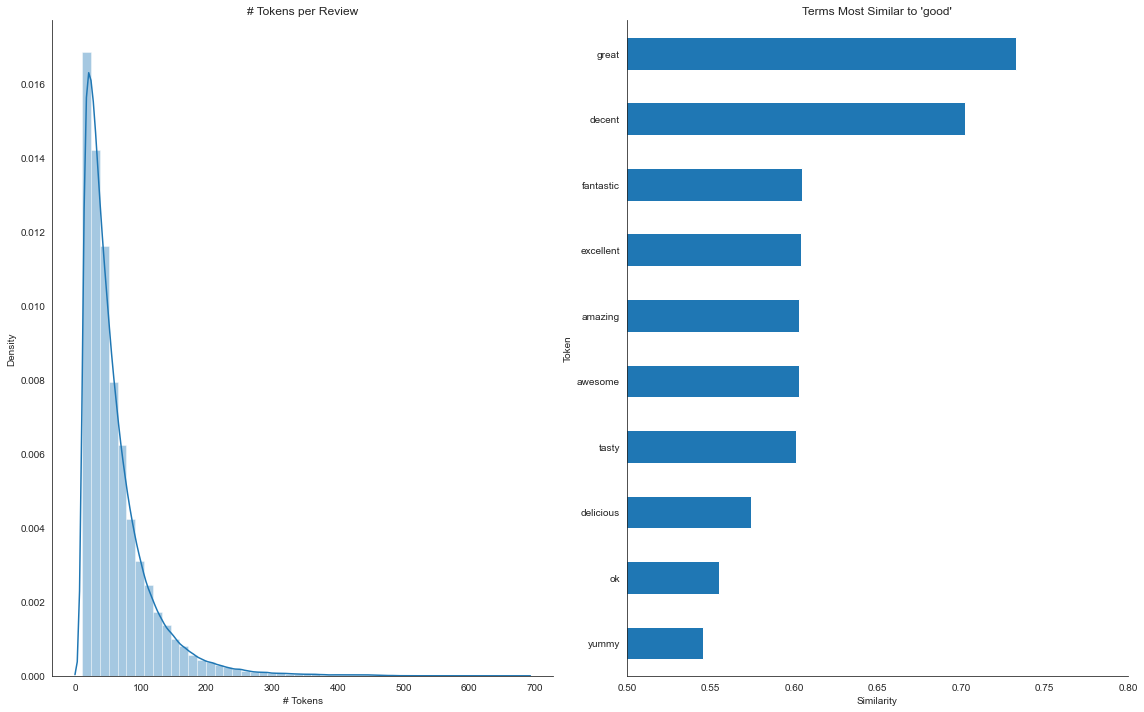

In [65]:
fig, axes =plt.subplots(ncols=2, figsize=(16, 10))
sns.distplot(sample.text.str.split().str.len(), ax=axes[0])
axes[0].set_title('# Tokens per Review')

most_similar.set_index('token').similarity.sort_values().plot.barh(ax=axes[1],
                                                                   title="Terms Most Similar to 'good'",
                                                                  xlim=(.5, .8))
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Token')
axes[0].set_xlabel('# Tokens')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'doc2vec_stats', dpi=300)

In [66]:
# Persist Model
model.save((results_path / 'sample.model').as_posix())
model = Doc2Vec.load((results_path / 'sample.model').as_posix())

# Evaluate
y = sample.stars.sub(1)
size = 300
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

X.shape

(485473, 300)

In [67]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.17%


In [69]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.99681228, 0.99167092, 0.99624974, 1.00146463, 1.01409473])

In [70]:
# LightGBM
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)
params = {'objective': 'multiclass', 'num_classes': 5, 'device':'gpu'}
lgb_model = lgb.train(params=params, train_set=train_data, num_boost_round=5000,
                      valid_sets=[train_data, test_data], early_stopping_rounds=25, verbose_eval=50)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 388378, number of used features: 300
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (111.12 MB) transferred to GPU in 0.053927 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.606245
[LightGBM] [Info] Start training from score -1.601074
[LightGBM] [Info] Start training from score -1.605681
[LightGBM] [Info] Start training from score -1.610901
[LightGBM] [Info] Start training from score -1.623434
Training until validation scores don't improve for 25 rounds
[50]	training's multi_logloss: 1.40723	valid_1's multi_logloss: 1.43703
[100]	training's multi_logloss: 1.33421	valid_1's multi_loglo

In [71]:
lgb_pred = np.argmax(lgb_model.predict(X_test), axis=1)
lgb_acc = accuracy_score(y_true=y_test, y_pred=lgb_pred)
print(f'Accuracy: {lgb_acc:.2%}')

Accuracy: 56.66%


In [72]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, verbose=1, class_weight='balanced_subsample')
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, verbose=1)

In [73]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)
print(f'Accuracy: {rf_acc:.2%}')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    5.0s


Accuracy: 37.26%


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    6.0s finished


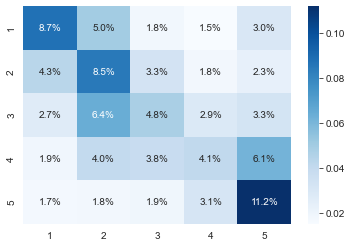

In [74]:
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), index=stars, columns=stars), annot=True, cmap='Blues', fmt='.1%');

In [75]:
# Multinomial Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_pred)
print(f'Accuracy: {lr_acc:.2%}')

Accuracy: 34.19%


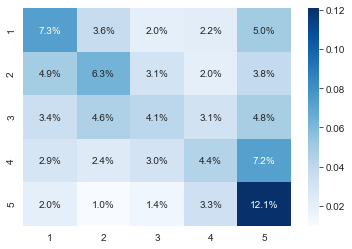

In [76]:
cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), index=stars, columns=stars), annot=True, cmap='Blues', fmt='.1%');

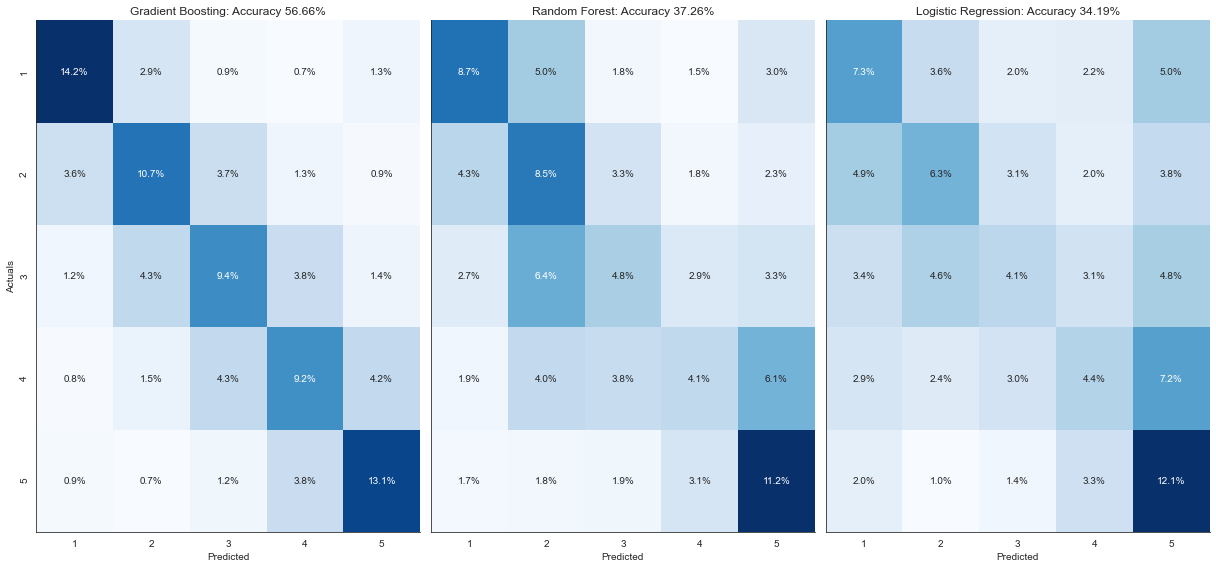

In [77]:
# Comparison
fig, axes = plt.subplots(ncols=3, figsize=(17, 8), sharex=True, sharey=True)

lgb_cm = confusion_matrix(y_true=y_test, y_pred=lgb_pred)
sns.heatmap(pd.DataFrame(lgb_cm/np.sum(lgb_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[0], cbar=False)
axes[0].set_title(f'Gradient Boosting: Accuracy {lgb_acc:.2%}')

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(rf_cm/np.sum(rf_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[1], cbar=False)
axes[1].set_title(f'Random Forest: Accuracy {rf_acc:.2%}')

lr_cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(lr_cm/np.sum(lr_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[2], cbar=False)
axes[2].set_title(f'Logistic Regression: Accuracy {lr_acc:.2%}')
axes[0].set_ylabel('Actuals')

for i in range(3):
    axes[i].set_xlabel('Predicted')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'confusion_matrix', dpi=300)